In [1]:
# For general analysis
library(tidyverse) #Specifically, tidyr, dplyr, stringr, ggplot2
library(readxl) # For reading crosslinking files
library(broom) # For model fits



# For plots
library(cowplot) # Formatting and assembling figures
library(ggridges)
library(ggrepel)
library(scales) # For scientific units

library(ggraph)
library(dendextend)
library(igraph)
library(tidygraph)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘cowplot’


The following object is masked from ‘package:ggplot2’:

    ggsave



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



---------------------
Welcome to dendextend version 1.14.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(pa

In [2]:
# function to plot
make_edge <- function(n, clu, cols){
    startcol = cols[n]
    endcol = cols[n + 1]
    clu %>% select(!!startcol, !!endcol) %>% rename(from = !!startcol, to = !!endcol)
}


format_clusters <- function(clusters, level_vect){
# Get clusters greater than one big
# Could be rewritted with new tidyeval syntax

  highest_level <- level_vect[1]
  clusters_filt <- clusters %>%
    add_count(!!sym(highest_level)) %>%
    filter(n > 1) %>%
    select(-n)
  
  
  # Make each cluster number unique by adding on the header
  clusters_uniqued_long <- clusters_filt %>%
    gather(clusterset, clusternum, -ID) %>%
    mutate(clusterid = paste0(clusternum, clusterset)) %>% 
    select(-clusternum)
  return(clusters_uniqued_long)

}


make_graph_clust <- function(clusters_uniqued_long, level_vect) {

  clusters_uniqued <- clusters_uniqued_long %>%
    spread(clusterset, clusterid)
    
  clusters_uniqued$link <- "origin"
  
  clusters_uniqued_sel <- clusters_uniqued %>%
    select(link, {{ level_vect }}, ID)
  
  cols <- names(clusters_uniqued_sel)
  
  edges <-
    map_df(seq(1, length(cols) - 1), make_edge, clusters_uniqued_sel, cols) %>%
    unique()
  
  mygraph2 <- as_tbl_graph(edges)
  
  return(mygraph2)
}

In [3]:
#no bordering
# Idea of this is to label only largest sets that label applies to 
# Also set that complex name as the label value for one member of largest set that that label applies to
format_labels <- function(clusters, annot, level_vect){
  
  # First get only selected clustering levels
  clusterid_annot <- clusters %>% left_join(annot, by = "ID") %>%
    filter(clusterset %in% {{ level_vect }}) %>%
    select(clusterset, clusterid, complex_label) %>%
  
    # Count numbers of members per cluster set
    group_by(clusterid) %>%
      mutate(unique_types = n_distinct(complex_label)) %>%
      add_count(clusterset, complex_label, sort = TRUE) %>%
    
    group_by(complex_label) %>%
      filter(unique_types ==  min(unique_types)) %>%
      mutate(label = case_when(row_number() == 1 ~ complex_label)) %>%
      filter(!is.na(label))  %>%
    group_by(clusterid) %>%
      summarize(label = paste(unique(label), collapse = ', ')) %>% 
    ungroup()

  return(clusterid_annot)
}


annotate_graph <- function(graph, clusterid_annot, annot)
{
  graph_annot <- graph %>% activate('nodes') %>%
    left_join(clusterid_annot, by = c("name"  = "clusterid")) %>%
    left_join(annot, by = c("name"  = "ID")) 
  return(graph_annot)

}

plot_graph <- function(graph, labels = TRUE){

  circlepack_plants_highlight <- ggraph(graph, layout = 'circlepack') + 
    geom_node_circle(aes(  fill = set), size = 0.1, color = "grey50") +
    scale_fill_manual(values = c(palette[4],  "yellow"), na.value = "white") + #light green "#c5f7d1
    theme(legend.key.size = unit(0.2, "lines"),
          legend.position = "bottom",
          legend.text = element_text(size = 4)) +
    theme_void() + 
    NULL

    if(labels == TRUE){
      # label nodes
      circlepack_plants_highlight <- circlepack_plants_highlight + 
        geom_node_text( aes( label= label), repel = TRUE,  segment.color = "grey40", size = 2, force = 0.5 ) +
        NULL
    }

  circlepack_plants_highlight_nolegend <- circlepack_plants_highlight + 
    theme(legend.position="FALSE")  
  return(circlepack_plants_highlight_nolegend)
}

circlepack_fxn <- function(graph_annot, seed){

 
  set.seed(seed = seed)
  base_layout_circlepack <- ggraph(graph_annot, layout = 'circlepack')

  base_layout_circlepack_format <- base_layout_circlepack +
    geom_node_circle(aes(fill = set)) +  #set is node coloring
    scale_fill_manual(values = c("#f2e600","#00f2ca",'grey', '#a45ee5'), na.value = NA) +
    #2988bc
    scale_color_manual(values = c("grey50"),na.value = "grey50") +
    scale_size_manual(values = c(1), na.value = 0.5) +
    theme_void() +
    geom_node_text(aes(label= gene_name), size = 1.5, color = "navy")
    

  #circlepackplot_clusterlabel <- base_layout_circlepack_format +
      #geom_node_text(aes(label= label), size = 1.5, color = "#400080") + #label is complex label
      #geom_node_text(aes(label= arath_genename), size = 1.5, color = "blue") + #arath_genename is labeling node by gene name
        #theme(legend.position="FALSE")+
        #NULL
  return(base_layout_circlepack_format)
}

In [4]:
#the cluster table only has rbc proteins
cluster_justrbc <- read_csv('/stor/work/Marcotte/project/Momo/rbc_figures/circlepack/category_annotated_modified_justrbc.csv') 
head(cluster_justrbc, 3)


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  cut_462.6 = col_double(),
  cut_411.2 = col_double(),
  cut_359.8 = col_double(),
  cut_308.4 = col_double(),
  cut_257 = col_double(),
  cut_205.6 = col_double(),
  cut_154.2 = col_double(),
  cut_102.8 = col_double(),
  cut_51.4 = col_double(),
  term_cytoskeleton = col_character(),
  term_energy = col_character(),
  term_redox = col_character(),
  term_proteostasis = col_character(),
  cumulated_terms = col_character(),
  `Protein names` = col_character(),
  `Gene names` = col_character(),
  label_rbc = col_character()
)




ID,cut_462.6,cut_411.2,cut_359.8,cut_308.4,cut_257,cut_205.6,cut_154.2,cut_102.8,cut_51.4,term_cytoskeleton,term_energy,term_redox,term_proteostasis,cumulated_terms,Protein names,Gene names,label_rbc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
O15145,13,67,89,125,160,200,241,278,319,cytoskeleton,NA,NA,NA,"['cytoskeleton', 'nan', 'nan', 'nan']",Actin-related protein 2/3 complex subunit 3 (Arp2/3 complex 21 kDa subunit) (p21-ARC),ARPC3 ARC21,rbc
P59998,13,22,33,116,150,188,226,261,301,cytoskeleton,NA,NA,NA,"['cytoskeleton', 'nan', 'nan', 'nan']",Actin-related protein 2/3 complex subunit 4 (Arp2/3 complex 20 kDa subunit) (p20-ARC),ARPC4 ARC20,rbc
O15144,13,22,33,45,51,64,75,84,107,cytoskeleton,NA,NA,NA,"['cytoskeleton', 'nan', 'nan', 'nan']",Actin-related protein 2/3 complex subunit 2 (Arp2/3 complex 34 kDa subunit) (p34-ARC),ARPC2 ARC34 PRO2446,rbc


In [5]:
#label each circle with gene names
uniprot_gene <- read_csv("/stor/work/Marcotte/project/Momo/diffusion_clustering/human_proteome_uiprotID_genename.csv")
uniprot_gene <- uniprot_gene %>% group_by(ID) %>% mutate(num=n()) %>% ungroup %>% filter(num==1)
head(uniprot_gene, 3) 


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  ID = col_character(),
  gene_name = col_character()
)




ID,gene_name,num
<chr>,<chr>,<int>
P61513,RPL37A,1
P17812,CTPS1,1
Q02878,RPL6,1


In [6]:
node_annot_bordering  <- read_csv('/stor/work/Marcotte/project/Momo/rbc_figures/circlepack/category_annotated_modified_justrbc_bordering_oxidoreductase.csv') 
head(node_annot_bordering, 3)


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  cut_462.6 = col_double(),
  cut_411.2 = col_double(),
  cut_359.8 = col_double(),
  cut_308.4 = col_double(),
  cut_257 = col_double(),
  cut_205.6 = col_double(),
  cut_154.2 = col_double(),
  cut_102.8 = col_double(),
  cut_51.4 = col_double(),
  count = col_double(),
  count_set = col_double()
)
ℹ Use `spec()` for the full column specifications.




ID,cut_462.6,cut_411.2,cut_359.8,cut_308.4,cut_257,cut_205.6,cut_154.2,cut_102.8,cut_51.4,...,term_proteostasis,count,cumulated_terms,count_set,set,unchar,Protein names,Gene names,label_rbc,unchar_edgecolor
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
O15145,13,67,89,125,160,200,241,278,319,...,NA,1,"['cytoskeleton', 'nan', 'nan', 'nan']",0,cytoskeleton,a,Actin-related protein 2/3 complex subunit 3 (Arp2/3 complex 21 kDa subunit) (p21-ARC),ARPC3 ARC21,rbc,NA
P59998,13,22,33,116,150,188,226,261,301,...,NA,1,"['cytoskeleton', 'nan', 'nan', 'nan']",0,cytoskeleton,a,Actin-related protein 2/3 complex subunit 4 (Arp2/3 complex 20 kDa subunit) (p20-ARC),ARPC4 ARC20,rbc,NA
O15144,13,22,33,45,51,64,75,84,107,...,NA,1,"['cytoskeleton', 'nan', 'nan', 'nan']",0,cytoskeleton,a,Actin-related protein 2/3 complex subunit 2 (Arp2/3 complex 34 kDa subunit) (p34-ARC),ARPC2 ARC34 PRO2446,rbc,NA


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(sel)` instead of `sel` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Warning message:
“Removed 523 rows containing missing values (geom_text).”
Warning message:
“Removed 523 rows containing missing values (geom_text).”


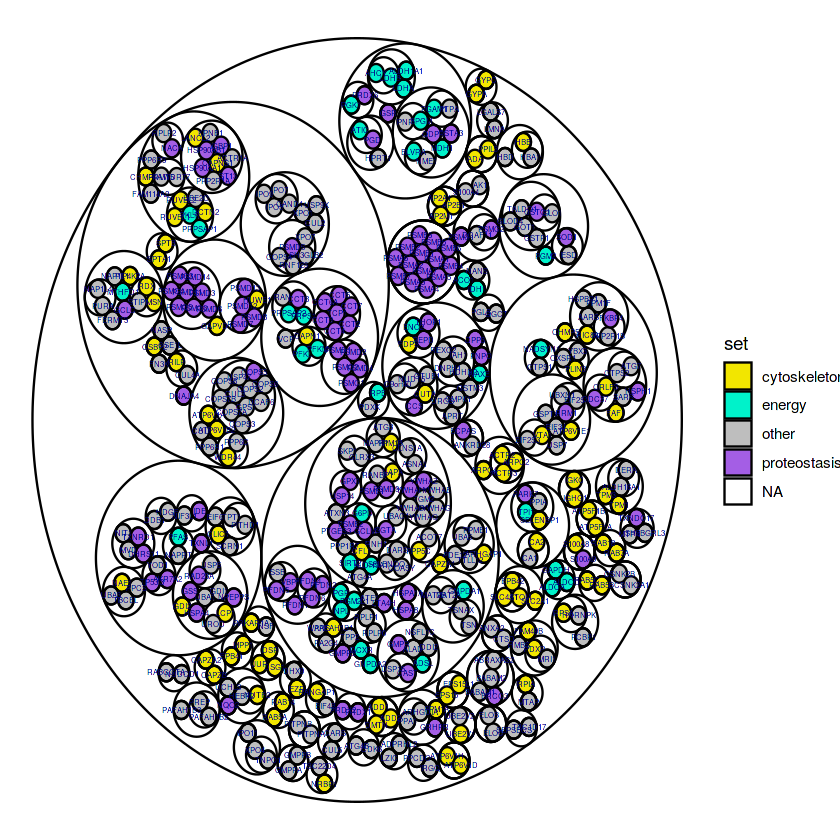

In [7]:
sel <- names(cluster_justrbc)[c(3,5,8)] 

clusters_uniqued_long <- format_clusters(cluster_justrbc, sel)

graph <- make_graph_clust(clusters_uniqued_long, sel)

graph <- graph %>% activate("nodes") %>%
    left_join(uniprot_gene, by = c("name" = "ID"))%>%
    left_join(node_annot_bordering, by = c("name"  = "ID")) 
circlepack_fxn(graph, 68)
ggsave("/stor/work/Marcotte/project/Momo/rbc_figures/circlepack/circlepackplot_category_cut358_rbconly_4cats_cb_friendly.pdf",
         device = "pdf", width = 6, height = 6, units = "in")